In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [2]:
if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')
  print('We will use the GPU: {}'.format(torch.cuda.get_device_name()))
  print('We have {} GPU(s) available'.format(torch.cuda.device_count()))
else:
  device = torch.device('cpu')
  print('No GPU available, using CPU instead')

We will use the GPU: Tesla K80
We have 1 GPU(s) available


In [4]:
! pip install transformers

# Get all possible models here: https://github.com/huggingface/transformers/blob/e6cff60b4cbc1158fbd6e4a1c3afda8dc224f566/examples/run_glue.py#L69

     |████████████████████████████████| 3.3 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 37.6 MB/s 
     |████████████████████████████████| 596 kB 54.3 MB/s 
     |████████████████████████████████| 61 kB 466 kB/s 
     |████████████████████████████████| 895 kB 38.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
! pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=64948c22d7c6a76480ba3e6c4ec0e5ddb9c8d83fc59bb563ff6dc0d01a5b129e
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [6]:
# Download the file (if we haven't already)

import wget
import os

url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_public_1.1.zip'):
  wget.download(url, './cola_public_1.1.zip')

In [7]:
# Unzip the dataset

if not os.path.exists('./cola_public/'):
  ! unzip cola_public_1.1.zip 

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [8]:
import pandas as pd

df = pd.read_csv('./cola_public/raw/in_domain_train.tsv', delimiter = '\t', header = None, names = ['Sentence_source', 'Label', 'Label_notes', 'Sentence'])
print(df.shape)
df

(8551, 4)


,Sentence_source,Label,Label_notes,Sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.
...,...,...,...,...
8546,ad03,0,*,Poseidon appears to own a dragon
8547,ad03,0,*,Digitize is my happiest memory
8548,ad03,1,NaN,It is easy to slay the Gorgon.
8549,ad03,1,NaN,I had the strangest feeling that I knew you.


In [9]:
df.loc[df.Label == 0].sample(5)[['Sentence', 'Label']]

,Sentence,Label
4474,I do not be happy.,0
6795,Henry wanted to possibly marry Fanny.,0
8126,Jason intended for PRO to learn magic.,0
3130,Paul breathed at Mary.,0
742,Aunt Mary made the boys all a good mother.,0


In [10]:
# Get the lists of sentences and their labels.

sentences = df.Sentence.values
labels = df.Label.values

In [11]:
# Load the BERT Tokenizer

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
print('Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))
# We can tokenize and convert tokens to IDs by using encode

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [13]:
max_len = 0

for sent in sentences:
  input_ids = tokenizer.encode(sent, add_special_tokens = True)
  max_len = max(max_len, len(input_ids))
  
print('Maximum sentence length: ', max_len)

Maximum sentence length:  47


In [14]:
# The tokenizer.encode_plus function combines multiple steps for us(First 4 are present in encode):

# Split the sentence into tokens.
# Add the special [CLS] and [SEP] tokens.
# Map the tokens to their IDs.
# Pad or truncate all sentences to the same length.
# Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.

In [15]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

input_ids = []
attention_masks = []

for sent in sentences:
  encoded_dict = tokenizer.encode_plus(sent, add_special_tokens=True, max_length=64, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0 now as a list of ids and attention mask

print('Original: ', sentences[0])
print('Token IDs: ', input_ids[0])
print('Attention_mask: ', attention_masks[0])
print('Label: ', labels[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs:  tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Attention_mask:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Label:  tensor(1)


In [16]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90/10 train validation split

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{} training samples'.format(train_size))
print('{} validation samples'.format(val_size))

7695 training samples
856 validation samples


In [17]:
# Create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because,
# unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, sampler = RandomSampler(train_dataset))

validation_dataloader = DataLoader(val_dataset, batch_size = batch_size, sampler = SequentialSampler(val_dataset))

In [18]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, output_attentions=False, output_hidden_states=False)

# Tell pytorch to run this model on GPU

model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [19]:
# Names and dimensions of the weights for the embedding layer, the first of the twelve transformers and the output layer.

In [20]:
params = list(model.named_parameters())
print('The BERT model has {} different named parameters'.format(len(params)))

# print('==== Embedding Layer ====\n')
# for p in params[0:5]:
#   print(p[0], p[1].size())

# print('\n==== First Transformer ====\n')
# for p in params[5:21]:
#   print(p[0], p[1].size())

# print('\n==== Output Layer ====\n')
# for p in params[-4]:
#   print(p[0], p[1].size())

print('==== Embedding Layer ====\n')
for p in params[0:5]:
  print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')
for p in params[5:21]:
  print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')
for p in params[-4:]:
  print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters
==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (76

In [21]:
# Grab the training hyperparameters from within the stored model
# Recommended: Batch size: 16, 32 || Learning rate (Adam): 5e-5, 3e-5, 2e-5 || Number of epochs: 2, 3, 4
# We chose: Batch size: 32 || Learning rate (Adam): 2e-5 || Number of epochs: 4
# The epsilon parameter eps = 1e-8 is "a very small number to prevent any division by zero in the implementation"

In [22]:
model.parameters()  # These are all the weights and biases to be learned in the model

<generator object Module.parameters at 0x7ff31c4567d0>

In [23]:
# AdamW is Adam weight decay fix - imporvement from Adam

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Default lr is 5e-5
# Default eps is 1e-8

In [24]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. We chose to run for 4, but we'll see later that this may be over-fitting the training data.

epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create learning rate scheduler

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)  # num_warmup_steps=0 : Default value in run_glue.py

In [25]:
# Calculate accuracy of our predictions vs labels

import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis = 1).flatten()
  labels.flat = labels.flatten()
  return np.sum(pred_flat == labels.flat) / len(labels.flat)

In [26]:
iter(train_dataloader).next()

[tensor([[ 101, 2984, 1005,  ...,    0,    0,    0],
         [ 101, 1996, 2482,  ...,    0,    0,    0],
         [ 101, 4463, 3832,  ...,    0,    0,    0],
         ...,
         [ 101, 2027, 2031,  ...,    0,    0,    0],
         [ 101, 3021, 2187,  ...,    0,    0,    0],
         [ 101, 2043, 5035,  ...,    0,    0,    0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
         1, 1, 0, 1, 1, 1, 0, 1])]

In [27]:
import time
import datetime
  
def format_time(elapsed):
  '''
  Takes a time in seconds and returns a string hh:mm:ss
  '''
  # Round to the nearest second.
  elapsed_rounded = int(round((elapsed)))
  
  # Format as hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [28]:
time.time()

1639132494.8019214

In [30]:
import random
import numpy as np
import time
import torch

# Set seed value for all values to reproduce the code
seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

training_stats = []
total_t0 = time.time()

for epoch in range(epochs):

  print('Epoch {}'.format(epoch))
  t0 = time.time()
  total_train_loss = 0

  model.train()   # Put the model into training mode - dropout` and `batchnorm` layers behave differently during training
  
  for step, batch in enumerate(train_dataloader):

    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    b_input_ids = batch[0].to(device)
    b_attention_masks = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    result = model(b_input_ids, token_type_ids=None, attention_mask=b_attention_masks, labels=b_labels, return_dict=True)
    loss = result.loss
    logits = result.logits
    total_train_loss += loss.item()

    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_train_loss / len(train_dataloader)
  print('Average training loss: {}'.format(avg_train_loss))

  training_time = format_time(time.time() - t0)
  print('Training epoch {} took {}'.format(epoch, training_time))

  print('Validation')

  t0 = time.time()

  model.eval()   # Put the model in evaluation mode--the dropout layers behave differently during evaluation

  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  for step, batch in enumerate(validation_dataloader):
    b_input_ids = batch[0].to(device)
    b_attention_masks = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training)
    with torch.no_grad():
      result = model(b_input_ids, token_type_ids=None, attention_mask=b_attention_masks, labels=b_labels, return_dict=True)

    loss = result.loss
    logits = result.logits

    total_eval_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # calculate the accuracy for this batch of test sentences and accumulate it over all batches
    total_eval_accuracy += flat_accuracy(logits, label_ids)

  avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
  print(len(validation_dataloader))
  print('Accuracy : {}'.format(avg_val_accuracy))

  avg_val_loss = total_eval_loss/ len(validation_dataloader)
  validation_time = format_time(time.time() - t0)
  print('Validation loss: {}'.format(avg_val_loss))
  print('Validation epoch {} took {} time'.format(epoch, validation_time))

  # Record all statistics from this epoch
  training_stats.append({'epoch': epoch+1, 'Training loss': avg_train_loss, 'Validation loss': avg_val_loss, 'Validation accuracy': avg_val_accuracy, 'Training time': training_time, 'Validation time': validation_time})

print('Traning complete')
print('Total training took {} time'.format(format_time(time.time() - total_t0)))

Epoch 0
  Batch    40  of    241.    Elapsed: 0:00:26.
  Batch    80  of    241.    Elapsed: 0:00:52.
  Batch   120  of    241.    Elapsed: 0:01:18.
  Batch   160  of    241.    Elapsed: 0:01:44.
  Batch   200  of    241.    Elapsed: 0:02:10.
  Batch   240  of    241.    Elapsed: 0:02:36.
Average training loss: 0.13146423923694123
Training epoch 0 took 0:02:37
Validation
27
Accuracy : 0.8406635802469137
Validation loss: 0.5942571748186041
Validation epoch 0 took 0:00:06 time
Epoch 1
  Batch    40  of    241.    Elapsed: 0:00:26.
  Batch    80  of    241.    Elapsed: 0:00:52.
  Batch   120  of    241.    Elapsed: 0:01:18.
  Batch   160  of    241.    Elapsed: 0:01:44.
  Batch   200  of    241.    Elapsed: 0:02:10.
  Batch   240  of    241.    Elapsed: 0:02:36.
Average training loss: 0.10714323411568134
Training epoch 1 took 0:02:37
Validation
27
Accuracy : 0.8414351851851852
Validation loss: 0.6795299298785351
Validation epoch 1 took 0:00:06 time
Epoch 2
  Batch    40  of    241.    Ela

In [31]:
training_stats

[{'Training loss': 0.13146423923694123,
  'Training time': '0:02:37',
  'Validation accuracy': 0.8406635802469137,
  'Validation loss': 0.5942571748186041,
  'Validation time': '0:00:06',
  'epoch': 1},
 {'Training loss': 0.10714323411568134,
  'Training time': '0:02:37',
  'Validation accuracy': 0.8414351851851852,
  'Validation loss': 0.6795299298785351,
  'Validation time': '0:00:06',
  'epoch': 2},
 {'Training loss': 0.13028505864587933,
  'Training time': '0:02:37',
  'Validation accuracy': 0.84375,
  'Validation loss': 0.6637748141807539,
  'Validation time': '0:00:06',
  'epoch': 3},
 {'Training loss': 0.12623879798259044,
  'Training time': '0:02:37',
  'Validation accuracy': 0.84375,
  'Validation loss': 0.6637748141807539,
  'Validation time': '0:00:06',
  'epoch': 4}]

In [32]:
import pandas as pd

pd.set_option('precision', 2)

df_stats = pd.DataFrame(data = training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training loss,Validation loss,Validation accuracy,Training time,Validation time
epoch,,,,,
1,0.13,0.59,0.84,0:02:37,0:00:06
2,0.11,0.68,0.84,0:02:37,0:00:06
3,0.13,0.66,0.84,0:02:37,0:00:06
4,0.13,0.66,0.84,0:02:37,0:00:06


In [33]:
# Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on.
# If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

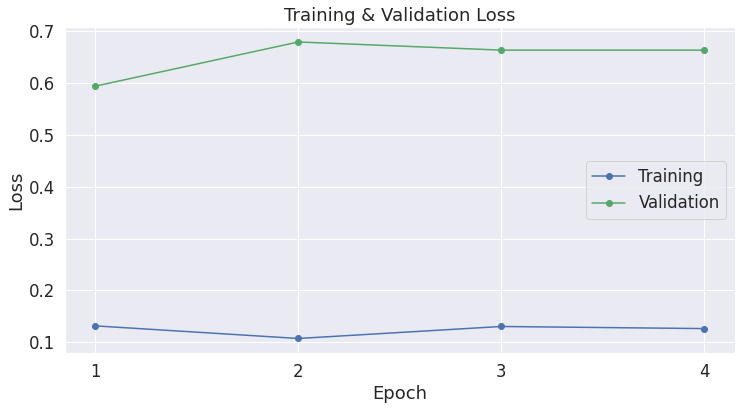

In [34]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training loss'], 'b-o', label="Training")
plt.plot(df_stats['Validation loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [35]:
# Apply same steps to test dataset

import pandas as pd

df_test = pd.read_csv('./cola_public/raw/in_domain_dev.tsv', delimiter = '\t', header = None, names = ['Sentence_source', 'Label', 'Label_notes', 'Sentence'])
print(df.shape)
df_test

(8551, 4)


,Sentence_source,Label,Label_notes,Sentence
0,gj04,1,NaN,The sailors rode the breeze clear of the rocks.
1,gj04,1,NaN,The weights made the rope stretch over the pul...
2,gj04,1,NaN,The mechanical doll wriggled itself loose.
3,cj99,1,NaN,"If you had eaten more, you would want less."
4,cj99,0,*,"As you eat the most, you want the least."
...,...,...,...,...
522,ad03,0,*,I would like to could swim
523,ad03,1,NaN,I kicked myself
524,ad03,0,*,The bookcase ran
525,ad03,1,NaN,I shaved myself.


In [36]:
# Get the lists of sentences and their labels.

test_sentences = df_test.Sentence.values
test_labels = df_test.Label.values

In [37]:
max_len = 0

for sent in test_sentences:
  input_ids = tokenizer.encode(sent, add_special_tokens = True)
  max_len = max(max_len, len(input_ids))
  
print('Maximum sentence length: ', max_len)

Maximum sentence length:  31


In [38]:
# Encoding just one sentence

encoded_dict = tokenizer.encode_plus(test_sentences[0], add_special_tokens=True, max_length=64, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')
print(encoded_dict)

{'input_ids': tensor([[  101,  1996, 11279,  8469,  1996,  9478,  3154,  1997,  1996,  5749,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [39]:
# Tokenize all of the test sentences and map the tokens to thier word IDs.

test_input_ids = []
test_attention_masks = []

for sent in test_sentences:
  test_encoded_dict = tokenizer.encode_plus(sent, add_special_tokens=True, max_length=64, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')
  test_input_ids.append(test_encoded_dict['input_ids'])
  test_attention_masks.append(test_encoded_dict['attention_mask'])

# Convert the lists into tensors

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [40]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

batch_size = 32

test_dataloader = DataLoader(test_dataset, batch_size = batch_size, sampler = SequentialSampler(test_dataset))

In [45]:
import random
import numpy as np
import time

t0 = time.time()

print('Testing')

model.eval()   # Put the model in evaluation mode--the dropout layers behave differently during evaluation

total_test_accuracy = 0
total_test_loss = 0
predictions = []
true_labels = []

for batch in test_dataloader:

  b_input_ids = batch[0].to(device)
  b_attention_masks = batch[1].to(device)
  b_labels = batch[2].to(device)

  # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training)
  with torch.no_grad():
    result = model(b_input_ids, token_type_ids=None, attention_mask=b_attention_masks, return_dict = True)
  # loss = result.loss
  logits = result.logits

  # total_test_loss += loss.item()

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)

  # calculate the accuracy for this batch of test sentences and accumulate it over all batches
  total_test_accuracy += flat_accuracy(logits, label_ids)

avg_test_accuracy = total_test_accuracy / len(test_dataloader)   # We will calculate accuracy(MCC) of entire test set by using pred and true labels
print(len(test_dataloader))
print('Accuracy : {}'.format(avg_test_accuracy))  

avg_test_loss = total_test_loss/ len(test_dataloader)
test_time = format_time(time.time() - t0)
print('Test loss: {}'.format(avg_test_loss))
print('Test testing took {} time'.format(test_time))

Testing
17
Accuracy : 0.8411764705882353
Test loss: 0.0
Test testing took 0:00:04 time


In [46]:
# Accuracy on the CoLA benchmark is measured using the "Matthews correlation coefficient" (MCC). This is the metric used by the wider NLP community to evaluate performance on CoLA.
# With this metric, +1 is the best score, and -1 is the worst score.

from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test bat5ch using Matthews correlation coefficient

for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0" and one column for "1"). Pick the label with the highest value and turn this in to a list of 0s and 1s
  # print('predictions[i]')
  # print(predictions[i])
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  # print('pred_labels_i')
  # print(pred_labels_i)
  # Calculate and store the coef for this batch
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

matthews_set

[0.4472135954999579,
 0.4472135954999579,
 0.4700159919404217,
 0.4526019054848144,
 0.8454106280193237,
 0.6397114734243627,
 0.717973623597536,
 0.777878154009821,
 0.5553906166205598,
 0.394853422012197,
 0.7453559924999299,
 0.8958064164776167,
 0.14285714285714285,
 1.0,
 0.6180700462007377,
 0.5056936741642399,
 0.533001790889026]

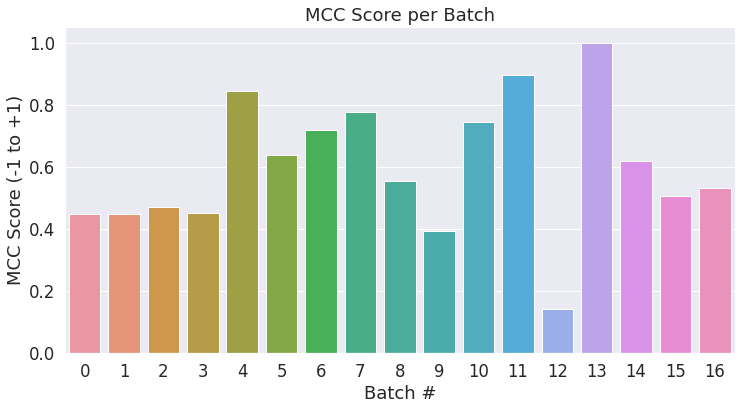

In [47]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [48]:
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('Total MCC: ', mcc)

Total MCC:  0.6138364753980826
